In [39]:
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/t.cri.yliang/labshare/GitHub/misc-tools/pyplot_tool/')
import plot_tools
sys.path.insert(0, '/home/t.cri.yliang/labshare/GitHub/mixqtl-gtex/postprocessing/functional_enrichment/')
import functional_enrichment
import io
import subprocess
import os
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [2]:
def merge(df, dfn, extract_col_dict, by_cols):
    tmp = dfn[list(extract_col_dict.keys()) + by_cols]
    tmp = tmp.rename(columns=extract_col_dict)
    if df is None:
        return tmp
    else:
        return pd.merge(df, tmp, on=by_cols)
def trim_dot(dd):
    return [ i.split('.')[0] for i in dd ]

def get_pval_mixqtl(p1, p2, p3):
    o = p1.copy()
    o[np.isnan(o)] = p2[np.isnan(o)]
    o[np.isnan(o)] = p3[np.isnan(o)]
    return o
def rename_col(df, method):
    if method == 'rasqual':
        return df.rename(columns={'Feature_ID': 'phenotype_id', 'rs_ID': 'variant_id'})
    elif method == 'eqtl':
        if 'gene_id' in df.columns:
            df['gene_id'] = trim_dot(df['gene_id'])
        return df.rename(columns={'gene_id': 'phenotype_id', 'pval_nominal': 'pval', 'slope': 'bhat'})
    elif method == 'mixqtl':
        return df
def clean_up_rasqual(df):
    # clean up rasqual
    tmp = df
    tmp = tmp[ tmp['Convergence_status_0success'] == 0 ].reset_index(drop=True)

    tmp['pval'] = scipy.stats.chi2.sf(tmp['Chi_square_statistic_2_x_log_Likelihood_ratio'], 1)
    tmp['bhat'] = np.log(tmp.Effect_size_Pi / (1 - tmp.Effect_size_Pi))
    df = rename_col(tmp, 'rasqual')
    df = df[['phenotype_id', 'variant_id', 'pval', 'bhat']]
    return df
def clean_up(df, method):
    df = rename_col(df, method)
    if method == 'mixqtl':
        # clean up mixqtl
        tmp = df
        tmp['pval'] = get_pval_mixqtl(tmp.pval_meta, tmp.pval_trc, tmp.pval_asc)
        tmp['bhat'] = get_pval_mixqtl(tmp.beta_meta, tmp.beta_trc, tmp.beta_asc)
        return tmp[['phenotype_id', 'variant_id', 'pval', 'bhat']]
    elif method == 'eqtl':
        # clean up eqtl
        return df[['phenotype_id', 'variant_id', 'pval', 'bhat']]
    elif method == 'rasqual':
        return clean_up_rasqual(df)
def read_from_cmd(cmd, kwargs={}):
    print(cmd)
    process = subprocess.check_output([cmd], stderr=subprocess.STDOUT, shell=True)
    csv = io.StringIO()
    for line in process.decode().split('\n'):
        csv.write(line.strip('"\n') + '\n')
    csv.seek(0)
    data = pd.read_csv(csv, **kwargs)
    csv.close()
    return data
def calc_maf(fpattern):
    e1 = pd.read_parquet(fpattern.format(hap_num=1))
    e1[ e1 == -1 ] = np.nan
    e2 = pd.read_parquet(fpattern.format(hap_num=2))
    e2[ e2 == -1 ] = np.nan
    maf = e1.mean(axis=1) + e2.mean(axis=1)
    maf = maf / 2
    return pd.DataFrame({'variant_id': maf.index, 'maf': maf})
    

In [3]:
file = {}
file['rasqual'] = '/home/t.cri.yliang/scratch/run-rasqual-results/kidney_cortex/rasqual_output.Kidney_Cortex.chr{chr_num}.parquet'
file['mixqtl'] = '/home/t.cri.yliang/scratch/mixQTL-GTExV8/mixqtl/Kidney_Cortex/mixqtl.Kidney_Cortex_GTEx_eGene.cis_qtl_pairs.mixQTL.chr{chr_num}.parquet'
file['eqtl'] = '/home/t.cri.yliang/scratch/mixQTL-GTExV8/split_eqtl/Kidney_Cortex/eqtl_allpairs.chr{chr_num}.parquet'
chrs = [ i for i in range(1, 23) ]

geno_pattern = '/home/t.cri.yliang/scratch/gtexv8_genotype_in_parquet/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01.chr{chr_num}.hap{{hap_num}}.parquet'

cache_file = 'cache_results_on_kidney_cortex.pkl.gz'
cache_maf = 'cache_maf.pkl.gz'

In [4]:
# get the list of variants
df_pairs = {}
for chr_num in chrs:
    fn = file['rasqual']
    fn = fn.format(chr_num=chr_num)
    dd = pd.read_parquet(fn)
    df_pairs[chr_num] = clean_up_rasqual(dd)

/home/t.cri.yliang/miniconda2/envs/mixqtl/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log


In [5]:
import gzip
import pickle
if not functional_enrichment.file_exists(cache_file):
    df = {}

    for i, fn in file.items():
        print(i)
        df[i] = []
        for chr_num in chrs:
            print(f'chr{chr_num} \r', end='')
            fn = file[i]
            fn = fn.format(chr_num=chr_num)
            tmp = pd.read_parquet(fn)
            tmp = rename_col(tmp, i)
            tmp = pd.merge(df_pairs[chr_num][['phenotype_id', 'variant_id']], tmp, on=['phenotype_id', 'variant_id'])
            tmp = clean_up(tmp, i)
            df[i].append(tmp)
        df[i] = pd.concat(df[i], axis=0)
        print('\n')
    with gzip.open(cache_file, 'wb') as f:
        pickle.dump(df, f)
else:
    with gzip.open(cache_file, 'rb') as f:
        df = pickle.load(f)

In [23]:
import gzip
import pickle
if not functional_enrichment.file_exists(cache_maf):
    df_maf = []

    
    for chr_num in chrs:
        print(f'chr{chr_num} \r', end='')
        fn = geno_pattern.format(chr_num=chr_num)
        tmp = calc_maf(fn)
        df_maf.append(tmp)
    df_maf = pd.concat(df_maf, axis=0)
        
    with gzip.open(cache_maf, 'wb') as f:
        pickle.dump(df_maf, f)
else:
    with gzip.open(cache_maf, 'rb') as f:
        df_maf = pickle.load(f)
        tmp = df_maf.maf.copy()
        tmp[ tmp > 0.5 ] = 1 - tmp[ tmp > 0.5 ]
        df_maf.maf = tmp

In [7]:
# merge all three
df_p = None
df_b = None
df_p = merge(df_p, df['rasqual'], extract_col_dict={'pval': 'rasqual'}, by_cols=['phenotype_id', 'variant_id'])
df_p = merge(df_p, df['mixqtl'], extract_col_dict={'pval': 'mixqtl'}, by_cols=['phenotype_id', 'variant_id'])
df_p = merge(df_p, df['eqtl'], extract_col_dict={'pval': 'eqtl'}, by_cols=['phenotype_id', 'variant_id'])
df_b = merge(df_b, df['rasqual'], extract_col_dict={'bhat': 'rasqual'}, by_cols=['phenotype_id', 'variant_id'])
df_b = merge(df_b, df['mixqtl'], extract_col_dict={'bhat': 'mixqtl'}, by_cols=['phenotype_id', 'variant_id'])
df_b = merge(df_b, df['eqtl'], extract_col_dict={'bhat': 'eqtl'}, by_cols=['phenotype_id', 'variant_id'])

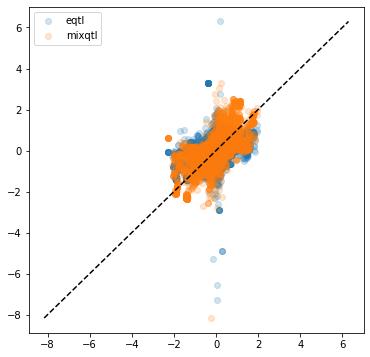

In [8]:
fig, axe = plt.subplots(1, 1, figsize=(6, 6))
plot_tools.scatter(
    [df_b['rasqual'], df_b['rasqual']],
    [df_b['eqtl'], df_b['mixqtl']],
    ['eqtl', 'mixqtl'],
    axe,
    {'alpha': 0.2}
)

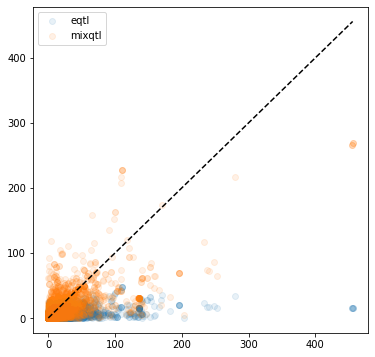

In [9]:
# subset
ind_sub = np.random.randint(0, df_p.shape[0], size=50000)
fig, axe = plt.subplots(1, 1, figsize=(6, 6))
plot_tools.scatter(
    [ -np.log(df_p['rasqual'][ind_sub]), -np.log(df_p['rasqual'][ind_sub]) ],
    [ -np.log(df_p['eqtl'][ind_sub]), -np.log(df_p['mixqtl'][ind_sub]) ],
    ['eqtl', 'mixqtl'],
    axe,
    {'alpha': 0.1}
)

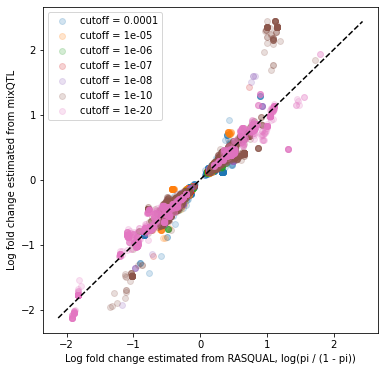

In [67]:
# both signif
inds = []
cutoffs = [ 1e-20, 1e-10, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4 ]

df_tmp = pd.DataFrame({'rasqual': df_b.rasqual, 'mixqtl': df_b.mixqtl})
label_ = np.array([ 'todo' for i in range(df_tmp.shape[0])])
for idx, cutoff in enumerate(cutoffs):
    if len(inds) > 0:
        indicator = ((df_p['mixqtl'] < cutoff) & (df_p['rasqual'] < cutoff)) & ((df_p['mixqtl'] >= cutoffs[idx - 1]) & (df_p['rasqual'] >= cutoffs[idx - 1]))
        inds.append(indicator)
        label_[indicator] = cutoff
    else:
        indicator = (df_p['mixqtl'] < cutoff) & (df_p['rasqual'] < cutoff)
        inds.append(indicator)
        label_[indicator] = cutoff

fig, axe = plt.subplots(1, 1, figsize=(6, 6))
plot_tools.scatter(
    [ df_b['rasqual'][ind] for ind in reversed(inds) ],
    [ df_b['mixqtl'][ind] for ind in reversed(inds) ],
    [ 'cutoff = {}'.format(co) for co in reversed(cutoffs) ],
    axe,
    {'alpha': 0.2}
)
axe.set_xlabel('Log fold change estimated from RASQUAL, log(pi / (1 - pi))')
axe.set_ylabel('Log fold change estimated from mixQTL')
fig.savefig("effect_size_kidney_cortex_100kb.png",dpi=(250), bbox_inches='tight')

In [72]:
df_b.head()

,rasqual,phenotype_id,variant_id,mixqtl,eqtl
0,-0.084310,ENSG00000000971,chr1_196603168_C_T_b38,-0.079969,-0.031461
1,-0.084310,ENSG00000000971,chr1_196603746_C_CTTAA_b38,-0.079969,-0.031461
2,-0.084310,ENSG00000000971,chr1_196604057_G_A_b38,-0.079969,-0.031461
3,-0.002856,ENSG00000000971,chr1_196604375_A_T_b38,-0.053764,-0.101900
4,-0.097016,ENSG00000000971,chr1_196606122_T_G_b38,-0.019167,0.098515


In [73]:
df_p.head()

,rasqual,phenotype_id,variant_id,mixqtl,eqtl
0,0.364374,ENSG00000000971,chr1_196603168_C_T_b38,0.232681,0.809115
1,0.364374,ENSG00000000971,chr1_196603746_C_CTTAA_b38,0.232681,0.809115
2,0.364374,ENSG00000000971,chr1_196604057_G_A_b38,0.232681,0.809115
3,0.967279,ENSG00000000971,chr1_196604375_A_T_b38,0.234668,0.338489
4,0.467839,ENSG00000000971,chr1_196606122_T_G_b38,0.855606,0.498563


In [74]:
df_p = pd.merge(df_p, df_maf[['variant_id', 'maf']], on='variant_id')

In [76]:
f1 = 'rasqual_kidney_cortex_100kb.pval.parquet'
f2 = 'rasqual_kidney_cortex_100kb.bhat.parquet'
if not functional_enrichment.file_exists(cache_maf):
    df_p.to_parquet(f1)
    df_b.to_parquet(f2)

In [77]:
# # both signif
# # stratify by MAF

# # annotate with maf
# maf = pd.merge(df_p, df_maf[['variant_id', 'maf']], on='variant_id')
# maf_b = pd.merge(df_b, df_maf[['variant_id', 'maf']], on='variant_id')

# # limit to pairs which are significant in both rasqual and mixqtl
# cutoff = 1e-4
# maf_b = maf_b[ (maf.rasqual < cutoff) & (maf.mixqtl < cutoff) ].reset_index(drop=True)
# maf = maf[ (maf.rasqual < cutoff) & (maf.mixqtl < cutoff) ].reset_index(drop=True)

# maf_quant = maf.maf.quantile(q=[i/10 for i in range(1, 11)])

# maf_cutoffs = maf_quant.tolist()
# maf_label = maf_quant.index.tolist()

# inds = []
# df_tmp = pd.DataFrame({'rasqual': maf_b.rasqual, 'mixqtl': maf_b.mixqtl})
# label_ = np.array([ 'todo' for i in range(df_tmp.shape[0])])
# for cutoff in maf_cutoffs:
#     if len(inds) > 0:
#         label_[(~inds[-1]) & (maf['maf'] < cutoff)] = cutoff
#         inds.append((~inds[-1]) & (maf['maf'] < cutoff))
#     else:
#         label_[maf['maf'] < cutoff] = cutoff
#         inds.append((maf['maf'] < cutoff))
#     print(label_)
# df_tmp['label'] = label_

        
# fig, axe = plt.subplots(1, 1, figsize=(6, 6))
# plot_tools.scatter(
#     [ maf_b['rasqual'][ind] for ind in reversed(inds) ],
#     [ maf_b['mixqtl'][ind] for ind in reversed(inds) ],
#     [ 'MAF bin = {}'.format(co) for co in reversed(maf_label) ],
#     axe,
#     {'alpha': 0.2}
# )
# axe.set_xlabel('Log fold change estimated from RASQUAL, log(pi / (1 - pi))')
# axe.set_ylabel('Log fold change estimated from mixQTL')
# fig.savefig("effect_size_kidney_cortex_100kb_by_maf.png",dpi=(250), bbox_inches='tight')

In [ ]:
fig, axe = plt.subplots(1, 1, figsize=(6, 6))
plot_tools.qqplot(
    [df_p['rasqual'], df_p['mixqtl'], df_p['eqtl']],
    ['rasqual', 'mixqtl', 'eqtl'],
    axe
)
fig.savefig("qqplot_kidney_cortex_100kb.png",dpi=(250), bbox_inches='tight')